# Cell Segmentation platform

## Connect to Google Drive

In [ ]:
# !nvidia-smi

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Download & unzip images

In [163]:
from IPython.display import clear_output
# !unzip drive/MyDrive/Self_Supervised/Dataset.zip -d /content/
# ! unzip drive/MyDrive/Research/Self-Supervised/Dataset_more_unlabeled.zip -d /content/
clear_output()

## Import Libraries

In [164]:
from IPython.display import clear_output 
%pip install Ipython
%pip install pytorch-metric-learning
%pip install --pre torch torchvision torchsummary --extra-index-url https://download.pytorch.org/whl/nightly/cpu
clear_output()

In [165]:
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from random import choice
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import random
import torch
import torchvision.transforms
from random import randint
import glob
device = torch.device('mps')

## Load Dataset

In [166]:
class MyDataset(Dataset):

    def __init__(self, dataset_dir, train_transform=None,target_transform=None):
        self.dataset_dir = dataset_dir
        self.data = glob.glob(dataset_dir+ "Image/*.png")
        self.train_transform = train_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        item_path = self.data[index]
        img_id = item_path.split("/")[-1].split(".")[0]
        item = np.array(Image.open(item_path))
        if item.shape[2] > 3:
          item = item[:,:,:3]
        item = Image.fromarray(item)
        label = Image.open(self.dataset_dir + "Label/" + img_id + ".png")
        
        if self.train_transform:
          item = self.train_transform(item)
        if self.target_transform:
          label = self.target_transform(label)
        return item, label

    def __len__(self):
        return len(self.data)

In [167]:
import torch

a = torch.Tensor([[1,2,3,4,5,6],[1,2,3,4,5,6]])
a[0:1,:]

tensor([[1., 2., 3., 4., 5., 6.]])

In [168]:
tf = transforms.Compose([transforms.ToTensor()])
tf_target = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset("Dataset/Labeled/",tf, tf)
len(dataset)

670

In [169]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [600, 50, 20],generator=torch.Generator().manual_seed(42))

In [170]:
train_loader = DataLoader(train_set, batch_size=32,
                          shuffle=True)  # num_workers=2
valid_loader = DataLoader(val_set, batch_size=25,
                          shuffle=False)  # num_workers=2
test_loader = DataLoader(test_set, batch_size=1,
                         shuffle=False)  # num_workers=0


## Define Metric

In [171]:
from skimage.morphology import label

def dice_coeff1(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum(1)
    return (2. * intersection + smooth) / (m1.sum(1) + m2.sum(1) + smooth)


def map_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def map_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = map_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    
    result = np.array(np.mean(metric), dtype=np.float32)
    return result

def MyLoss(pred, target):
  loss1 = nn.BCEWithLogitsLoss()
  return  dice_coeff1(pred, target) + loss1(pred, target)

More Standard Metrics (Mean IoU, Mean Accuracy, Mean Precision, Mean Recall, Mean F1 Score):

In [172]:
from pytorch_lightning.metrics import Accuracy, Precision, Recall, F1


class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return IoU


def mean_iou_metric(y_true_in, y_pred_in, debugging_mode=False):
    # Use IoU metric from Pytorch Lightning
    iou = IoU()
    return iou(y_pred_in, y_true_in)


def mean_iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = mean_iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)

    result = np.array(np.mean(metric), dtype=np.float32)
    return result


def mean_acc_metric(y_true_in, y_pred_in, debugging_mode=False):
    # Use Accuacy metric from Pytorch Lightning
    acc = Accuracy()
    return acc(y_pred_in, y_true_in)


def mean_acc_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = mean_acc_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)

    result = np.array(np.mean(metric), dtype=np.float32)
    return result


def mean_prec_metric(y_true_in, y_pred_in, debugging_mode=False):
    # Use Precision metric from Pytorch Lightning
    prec = Precision()
    return prec(y_pred_in, y_true_in)


def mean_prec_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = mean_prec_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)

    result = np.array(np.mean(metric), dtype=np.float32)
    return result


def mean_rec_metric(y_true_in, y_pred_in, debugging_mode=False):
    # Use Recall metric from Pytorch Lightning
    rec = Recall()
    return rec(y_pred_in, y_true_in)


def mean_rec_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = mean_rec_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)

    result = np.array(np.mean(metric), dtype=np.float32)
    return result


def mean_f1_metric(y_true_in, y_pred_in, debugging_mode=False):
    # Use F1 metric from Pytorch Lightning
    f1 = F1()
    return f1(y_pred_in, y_true_in)


def mean_f1_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = mean_f1_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)

    result = np.array(np.mean(metric), dtype=np.float32)
    return result


## Train & Test Functions

In [173]:
def train(model, t_loader, v_loader, criterion, optimizer, scheduler=None, epochs=100,
          verbose=1, model_name='model', dir=''):
    model.train()
    scheduler = scheduler
    # torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, factor=0.8, patience=40, verbose=True)
    best_score = np.array([0, 0, 0, 0, 0, 0], dtype=np.float32)
    log_train_loss = []
    log_val_loss = []
    log_val_score = []

    for epoch in range(epochs):
        train_loss = 0
        train_n = 0

        # TRAINING LOOP
        for idx, (x, y) in enumerate(t_loader):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            optimizer.zero_grad()
            loss = criterion(outputs, y)
            train_loss += loss.item() * y.size(0)
            train_n += y.size(0)
            loss.backward()
            optimizer.step()
        train_loss = train_loss / train_n
        if scheduler:
            scheduler.step(epoch)
        _, train_score = evaluate(model, t_loader, criterion, device)
        log = '\r{}\ntrain_loss:{:.4f}\ttrainig_score:{}\n'.format(
            epoch + 1, train_loss, train_score)

        val_loss, val_score = evaluate(model, v_loader, criterion, device)
        if (val_score > best_score).any():
            torch.save(model.state_dict(), dir + model_name + ".pth")
            best_score = val_score
        log += '  val_loss:{:.4f}\tval_scores: \n MaP: {:.4f} | Mean_Recall: {:.4f} | Mean_Prec: {:.4f} \n \
        | Mean_F1: {:.4f} | Mean_IoU: {:.4f} | Mean_Acc: {:.4f}'.format(val_loss, val_score[0], val_score[1], val_score[2], val_score[3], val_score[4], val_score[5])

        log_train_loss.append(train_loss)
        log_val_loss.append(val_loss)
        log_val_score.append(val_score)

        if (epoch + 1) % verbose == 0:
            print(log)

    return log_train_loss, log_val_loss, log_val_score


def evaluate(model, loader, criterion, device):
    model.eval()

    # VALIDATION LOOP
    with torch.no_grad():
        val_loss = 0
        val_score = np.array([0, 0, 0, 0, 0, 0], dtype=np.float32)
        val_n = 0
        score = np.array([0, 0, 0, 0, 0, 0], dtype=np.float32)

        for idx, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y).item()

            outputs = torch.sigmoid(outputs)
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0

            outputs = outputs.reshape(outputs.shape[0], outputs.shape[-1], outputs.shape[-1])
            y = y.reshape(y.shape[0], y.shape[-1], y.shape[-1])

            score[0] = map_metric_batch(
                outputs.cpu().detach(), y.cpu().detach())
            score[1] = mean_rec_metric_batch(
                outputs.cpu().detach(), y.cpu().detach())
            score[2] = mean_prec_metric_batch(
                outputs.cpu().detach(), y.cpu().detach())
            score[3] = mean_f1_metric_batch(
                outputs.cpu().detach(), y.cpu().detach())
            score[4] = mean_iou_metric_batch(
                outputs.cpu().detach(), y.cpu().detach())
            score[5] = mean_acc_metric_batch(
                outputs.cpu().detach(), y.cpu().detach())

            val_loss += loss * y.size(0)
            val_score[0] += score[0] * y.size(0)
            val_score[1] += score[1] * y.size(0)
            val_score[2] += score[2] * y.size(0)
            val_score[3] += score[3] * y.size(0)
            val_score[4] += score[4] * y.size(0)
            val_score[5] += score[5] * y.size(0)

            val_n += y.size(0)
        val_loss = val_loss / val_n
        val_score = val_score / val_n
    model.train()
    return val_loss, val_score


## Contrastive Learning

In [174]:
def contrastive_learning(head, model_name, dir, train_loader, criterion, optimizer, start_epoch=0, n_epochs =100, MoCo = False):
    # train_loss_values = []
    best_loss = 10000
    for epoch in range(start_epoch, n_epochs):
        print(' \n -- Epoch: {}'.format(epoch + 1))
        train_loss = 0
        head.train()
        for iteration, sample in enumerate(train_loader):
            img , aug_img = sample[0], sample[1]
            optimizer.zero_grad()
            # compute output
            img , aug_img = img.to(device) , aug_img.to(device)
            if MoCo:
              loss = model(img, aug_img)
            else:
              inputsize = img.size(0)
              data = torch.cat((img, aug_img), 0)
              labels = torch.arange(inputsize)
              labels = torch.cat((labels, labels))
              output  = head(data.to(device))

              # if device.type == 'cuda':
              #   print(torch.cuda.get_device_name(0))
              #   print('Memory Usage:')
              #   print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
              #   print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
                
              loss = criterion(output , labels)  
            loss.sum().backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_loader.sampler)
        # train_loss_values.append(train_loss)
        print('\nEpoch: {} \tTraining Loss: {:.8f}'.format(epoch + 1, train_loss))
        if train_loss < best_loss:
          best_loss = train_loss
          # torch.save(head.state_dict(),dir + "/"+ model_name +"_"+ str(epoch) +".mdl")
          checkpoint = {'epoch': epoch, 'model': head.state_dict(), 'optimizer': optimizer.state_dict()}
          torch.save(checkpoint, dir + "/"+ model_name + '_checkpoint_' + str(epoch) + '.pth')
          # torch.save(encoder.state_dict(),dir+ "/encoder_"+ str(epoch) +".mdl")
          print("Model saved successfully in epoch {}".format(epoch + 1))

In [175]:
int(1/3)

0

## General Function

In [176]:
def General(model, model_name, dir, optimizer_name = 'adam',scheduler=False, lr = 0.001, weight_decay = 1e-5, n_epochs =100, verbose=1):
  criterion = nn.BCEWithLogitsLoss()
  if optimizer_name == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  schd = None
  if scheduler:
    schd = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=40, verbose=True)
  return train(model, train_loader, valid_loader, criterion, optimizer, schd,n_epochs, verbose, model_name, dir)

## Supervised

### UNET

In [177]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self, n_classes=1, n_channels= 3, base_channel=32 , bilinear=True):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, base_channel)
        self.down1 = Down(base_channel, 2 * base_channel)
        self.down2 = Down(2 * base_channel, 4 * base_channel)
        self.down3 = Down(4 * base_channel, 8 * base_channel)
        factor = 2 if bilinear else 1
        self.down4 = Down(8 * base_channel, 16 * base_channel // factor)
        # self.conv = nn.Conv2d(16*base_channel, 16*base_channel, kernel_size=1)
        self.up1 = Up(16 * base_channel, 8 * base_channel // factor, bilinear)
        self.up2 = Up(8 * base_channel, 4 * base_channel // factor, bilinear)
        self.up3 = Up(4 * base_channel, 2 * base_channel // factor, bilinear)
        self.up4 = Up(2 * base_channel, base_channel, bilinear)
        self.outc = OutConv(base_channel, n_classes)

    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        h = self.up1(x5, x4)
        h = self.up2(h, x3)
        h = self.up3(h, x2)
        h = self.up4(h, x1)
        h = self.outc(h)
        return h

In [ ]:
model = Unet().to(device)
train_loss, val_loss, val_score = General(model, 'UNET_Supervised', 
                                          "./models_v3/", 
                                          'adam',False,0.001, 1e-5, 100,1)

In [ ]:
max(val_score)

In [178]:
model_unet = Unet().to(device)
model_unet.load_state_dict(torch.load("./models_v3/UNET_Supervised.pth"))
criterion = nn.BCEWithLogitsLoss()
evaluate(model_unet, test_loader, criterion, device)

(0.04047813543584198,
 array([0.5830749 , 0.90087116, 0.91827154, 0.90642273, 0.8328856 ,
        0.9851128 ], dtype=float32))

## Self-Supervised

### Unlebeled Dataset

In [179]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import random
import torch
import torchvision.transforms
from random import randint


def rotate(image):
    angles = [90, 180, 270]
    i = random.randint(0, 2)
    new_image = TF.rotate(image, angles[i])
    return new_image


def cutout(image):
    number_of_cut_outs = randint(2, 10)
    colors = [0, 255]
    i = random.randint(0, 1)
    color = colors[i]
    sizes = [20, 30, 40, 50, 60]
    i = random.randint(0, 4)
    size = sizes[i]
    image_copy = image
    for i in range(number_of_cut_outs):
        image_new = torchvision.transforms.ToTensor()(image_copy)
        i = random.randint(0, image_new.shape[1] - 30)
        j = random.randint(0, image_new.shape[2] - 30)
        # c = 0 if color == 'black' else 255)
        im = TF.erase(image_new, i, j, size, size, torch.tensor(color))
        image_copy = im.permute(1, 2, 0).numpy()
    return image_copy


def edge_detection_laplacian(image):
    k = random.randint(1, 4) * 2 + 1
    open_cv_image = np.array(image)[:, :, ::-1].copy()
    laplacian = cv2.Laplacian(open_cv_image, cv2.CV_64F, ksize=k)
    return laplacian


def edge_detection_sobelx(image):
    k = random.randint(1, 15) * 2 + 1
    open_cv_image = np.array(image)[:, :, ::-1].copy()
    sobelx = cv2.Sobel(open_cv_image, cv2.CV_64F, 1, 0, ksize=k)
    return sobelx


def edge_detection_sobely(image):
    k = random.randint(1, 15) * 2 + 1
    open_cv_image = np.array(image)[:, :, ::-1].copy()
    sobely = cv2.Sobel(open_cv_image, cv2.CV_64F, 0, 1, ksize=k)
    return sobely


def gaussian_blur(image):
    k = random.randint(1, 3) * 2 + 1
    image_new = torchvision.transforms.ToTensor()(image)
    blured = torchvision.transforms.functional.gaussian_blur(
        image_new, kernel_size=k).permute(1, 2, 0).numpy()
    return blured
# todo gaussian noise


def crop_and_resize(image):
    array_img = np.array(image)
    top = random.randint(0, array_img.shape[0] - 30)
    left = random.randint(0, array_img.shape[1] - 30)
    height = random.randint(0, array_img.shape[0] - top)
    width = random.randint(0, array_img.shape[1] - left)
    cropped = torchvision.transforms.functional.resize(torchvision.transforms.functional.crop(
        image, top, left, height, width), (array_img.shape[0], array_img.shape[1]))
    return cropped


In [180]:
np.random.seed(0)


class GaussianBlur(object):
    """blur a single image on CPU"""
    def __init__(self, kernel_size):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.blur_h = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1),
                                stride=1, padding=0, bias=False, groups=3)
        self.blur_v = nn.Conv2d(3, 3, kernel_size=(1, kernel_size),
                                stride=1, padding=0, bias=False, groups=3)
        self.k = kernel_size
        self.r = radias

        self.blur = nn.Sequential(
            nn.ReflectionPad2d(radias),
            self.blur_h,
            self.blur_v
        )

        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)

        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)

        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))

        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()

        img = self.tensor_to_pil(img)

        return img

In [181]:
class MyDataset_unlabeled(Dataset):
    def __init__(self, path):
      super().__init__()
      self.images = torchvision.datasets.ImageFolder(root = path)

    def __len__(self):
      return len(self.images)

    def __getitem__(self, index):
      img = self.images[index][0]
      transform = transforms.Compose([  
            transforms.ToTensor()])
      
      # transform= transforms.Compose([transforms.RandomResizedCrop(size=256),
      #                                 transforms.RandomHorizontalFlip(),
      #                                 transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
      #                                 transforms.RandomGrayscale(p=0.2),
      #                                 GaussianBlur(kernel_size=int(0.1 * 256)),
      #                                 transforms.ToTensor()])
      # aug_img_1 = transform(cutout(edge_detection_laplacian(img)))
      # aug_img_2 = transform(cutout(edge_detection_laplacian(img)))

      # aug_img_1 = transform(edge_detection_laplacian(rotate(img)))
      # aug_img_2 = transform(edge_detection_laplacian(rotate(img)))

      # aug_img_1 = transform(edge_detection_laplacian(img))
      # aug_img_2 = transform(edge_detection_laplacian(img))

      # aug_img_1 = transform(cutout(img))
      # aug_img_2 = transform(cutout(img))

      # aug_img_1 = transform(img)
      # aug_img_2 = transform(edge_detection_laplacian(img))

      # aug_img_1 = transform(edge_detection_laplacian(Image.fromarray((cutout(img) * 255).astype(np.uint8))))
      # aug_img_2 = transform(edge_detection_laplacian(Image.fromarray((cutout(img) * 255).astype(np.uint8))))
      aug_img_1 = transform(gaussian_blur(rotate(img)))
      aug_img_2 = transform(gaussian_blur(edge_detection_laplacian(img)))
      # aug_img_1 = transform(img)
      # aug_img_2 = transform(img)
      # img = transform(img)
      return transform(img), aug_img_1, aug_img_2

In [182]:
unlabeled_dataset = MyDataset_unlabeled("Dataset/unLabeled/")
# moco
u_loader = DataLoader(unlabeled_dataset, batch_size=40,
                      shuffle=True, drop_last=False)  # num_workers=0

In [183]:
len(u_loader)

93

In [184]:
a, b, c = next(iter(u_loader))

In [185]:
from torchvision.utils import save_image

for i in range(5):
  save_image(a[i], "img_" + str(i) + ".png")
  save_image(b[i], "img_Aug1_" + str(i) + ".png")
  save_image(c[i], "img_Aug2_" + str(i) + ".png")

Showing Saved Images (Image + Augmented_1 + Augmented_2):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


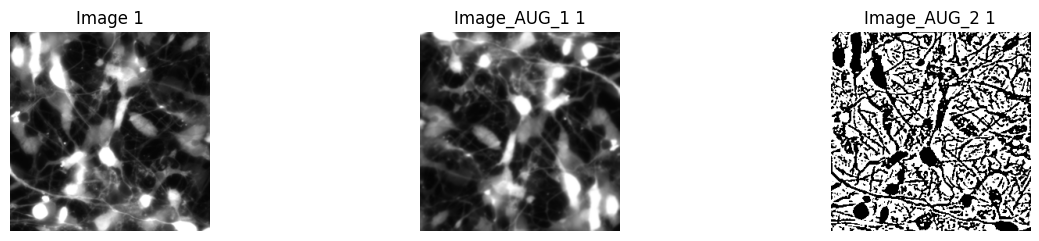

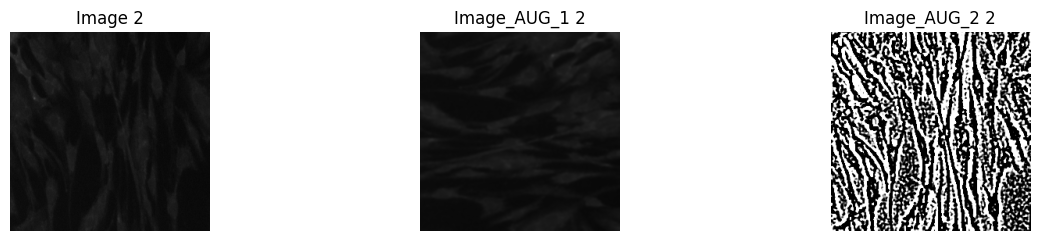

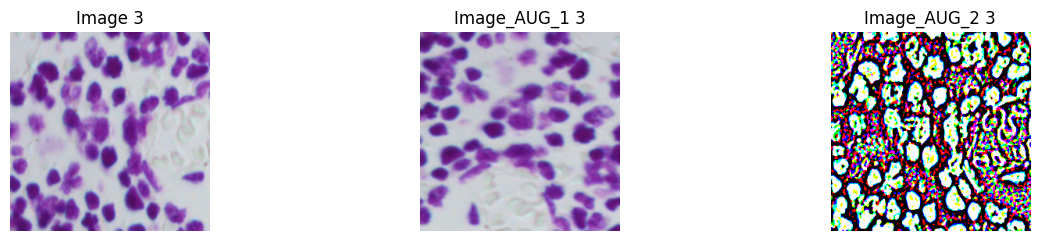

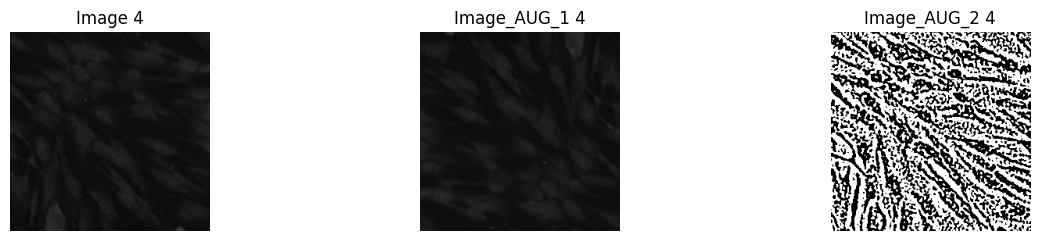

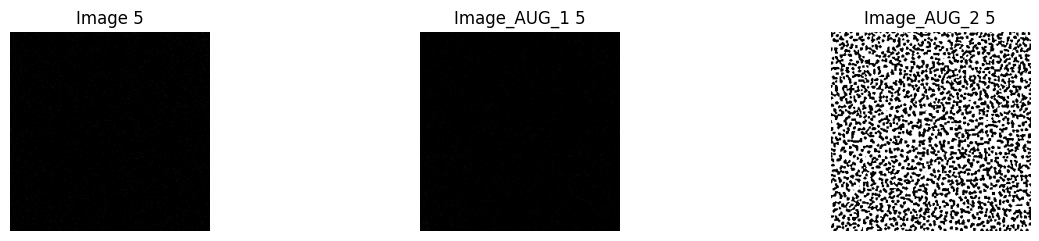

In [186]:
for i in range(5):
    fig = plt.figure(figsize=(15, 15))
    fig.add_subplot(5, 3, 1)
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.imshow(a[i].permute(1, 2, 0))
    fig.add_subplot(5, 3, 2)
    plt.axis('off')
    plt.title(f"Image_AUG_1 {i+1}")
    plt.imshow(b[i].permute(1, 2, 0))
    fig.add_subplot(5, 3, 3)
    plt.axis('off')
    plt.title(f"Image_AUG_2 {i+1}")
    plt.imshow(c[i].permute(1, 2, 0))


### SimCLR

In [187]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
        
class Unet_encoder(nn.Module):
  def __init__(self, n_channels= 3, base_channel=64 , bilinear=True):
        super(Unet_encoder, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, base_channel)
        self.down1 = Down(base_channel, 2 * base_channel)
        self.down2 = Down(2 * base_channel, 4 * base_channel)
        self.down3 = Down(4 * base_channel, 8 * base_channel)
        factor = 2 if bilinear else 1
        self.down4 = Down(8 * base_channel, 16 * base_channel // factor)
        # self.conv = nn.Conv2d(16*base_channel, 16*base_channel, kernel_size=1)
        # self.up1 = Up(16 * base_channel, 8 * base_channel // factor, bilinear)
        # self.up2 = Up(8 * base_channel, 4 * base_channel // factor, bilinear)
        # self.up3 = Up(4 * base_channel, 2 * base_channel // factor, bilinear)
        # self.up4 = Up(2 * base_channel, base_channel, bilinear)
        # self.outc = OutConv(base_channel, n_classes)
        # self.act = nn.Sigmoid()
  def forward(self, x):
      x1 = self.inc(x)
      x2 = self.down1(x1)
      x3 = self.down2(x2)
      x4 = self.down3(x3)
      x5 = self.down4(x4)
      # h = self.act(h)
      return x1, x2, x3, x4, x5

class Unet(nn.Module):
    def __init__(self, encoder, n_classes=1, base_channel=64 , bilinear=True):
        super(Unet, self).__init__()
        # self.n_channels = n_channels
        self.bilinear = bilinear
        self.encoder = encoder
        # self.inc = DoubleConv(n_channels, base_channel)
        # self.down1 = Down(base_channel, 2 * base_channel)
        # self.down2 = Down(2 * base_channel, 4 * base_channel)
        # self.down3 = Down(4 * base_channel, 8 * base_channel)
        factor = 2 if bilinear else 1
        # self.down4 = Down(8 * base_channel, 16 * base_channel // factor)
        # self.conv = nn.Conv2d(16*base_channel, 16*base_channel, kernel_size=1)
        self.up1 = Up(16 * base_channel, 8 * base_channel // factor, bilinear)
        self.up2 = Up(8 * base_channel, 4 * base_channel // factor, bilinear)
        self.up3 = Up(4 * base_channel, 2 * base_channel // factor, bilinear)
        self.up4 = Up(2 * base_channel, base_channel, bilinear)
        self.outc = OutConv(base_channel, n_classes)
        # self.act = nn.Sigmoid()

    
    def forward(self, x):
        x1, x2, x3, x4, x5 = self.encoder(x)
        h = self.up1(x5, x4)
        h = self.up2(h, x3)
        h = self.up3(h, x2)
        h = self.up4(h, x1)
        h = self.outc(h)
        # h = self.act(h)
        return h


class MainUnet(nn.Module):
    def __init__(self, n_classes=1,n_channels= 3, base_channel=64 , bilinear=True):
        super(MainUnet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear
        # self.encoder = encoder
        self.inc = DoubleConv(n_channels, base_channel)
        self.down1 = Down(base_channel, 2 * base_channel)
        self.down2 = Down(2 * base_channel, 4 * base_channel)
        self.down3 = Down(4 * base_channel, 8 * base_channel)
        factor = 2 if bilinear else 1
        self.down4 = Down(8 * base_channel, 16 * base_channel // factor)
        # self.conv = nn.Conv2d(16*base_channel, 16*base_channel, kernel_size=1)
        self.up1 = Up(16 * base_channel, 8 * base_channel // factor, bilinear)
        self.up2 = Up(8 * base_channel, 4 * base_channel // factor, bilinear)
        self.up3 = Up(4 * base_channel, 2 * base_channel // factor, bilinear)
        self.up4 = Up(2 * base_channel, base_channel, bilinear)
        self.outc = OutConv(base_channel, n_classes)
        # self.act = nn.Sigmoid()

    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        h = self.up1(x5, x4)
        h = self.up2(h, x3)
        h = self.up3(h, x2)
        h = self.up4(h, x1)
        h = self.outc(h)
        # h = self.act(h)
        return h


class HeadProjection(nn.Module):
    def __init__(self, n_classes=3, base_channel=64, unet=Unet , bilinear=True):
        super(HeadProjection, self).__init__()
        self.n_classes = n_classes
        # self.bilinear = bilinear
        self.unet = unet

        # factor = 2 if bilinear else 1
        # self.up1 = Up(16 * base_channel, 8 * base_channel // factor, bilinear)
        # self.up2 = Up(8 * base_channel, 4 * base_channel // factor, bilinear)
        # self.up3 = Up(4 * base_channel, 2 * base_channel // factor, bilinear)
        # self.up4 = Up(2 * base_channel, base_channel, bilinear)
        # self.outc = OutConv(base_channel, n_classes)
        # self.outc2 = OutConv(n_classes , 1)
        self.convv = nn.Conv2d(n_classes,1,kernel_size=7 , padding= 0 , stride = 3)
        self.fc = nn.Linear(84*84,64)
        # self.act = nn.ReLU()
    
    def forward(self, x):
        h = self.unet(x)
        # h = self.up1(x5, x4)
        # h = self.up2(h, x3)
        # h = self.up3(h, x2)
        # h = self.up4(h, x1)
        # x = self.outc(h)
        h = self.convv(h)
        h = torch.flatten(h , start_dim = 1)
        h = self.fc(h)
        return h

In [188]:
from IPython.display import clear_output
# !unzip drive/MyDrive/Self_Supervised/last_epoch.zip -d /content/models_v3/
clear_output()

In [189]:
from torchsummary import summary
from pytorch_metric_learning.losses import NTXentLoss

checkpoint = torch.load(
    "./models_v3/Phase3_last_checkpoint.pth", map_location=torch.device('mps'))
# encoder = Unet_encoder(3,32)
# unet = Unet(encoder, 1, 32)
enc = Unet_encoder(3, 32).to(device)
unet = Unet(enc, 1, 32).to(device)
head = HeadProjection(1, 32, unet).to(device)
optimizer = torch.optim.Adam(head.parameters(), lr=0.001, weight_decay=1e-5)
criterion = NTXentLoss(temperature=0.5)
head.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])
# s_epoch = checkpoint["epoch"]
s_epoch = 100
# summary(head, input_size=(3, 256, 256))


In [190]:
contrastive_learning(head,"Phase3" ,"/content/models_v3",u_loader, criterion,optimizer,start_epoch=s_epoch,n_epochs=100)

In [191]:
import gc
gc.collect()

30503

In [192]:
x,y,z = next(iter(u_loader))

In [193]:
unet = head.unet

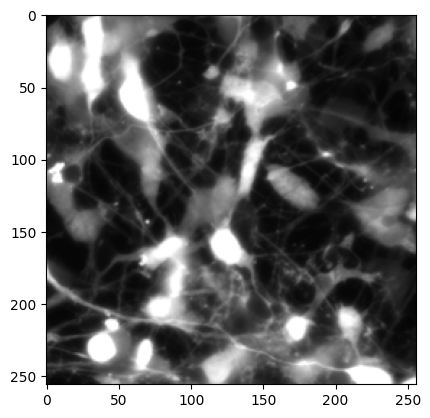

In [194]:
img = Image.open("img_0.png")
convert_tensor = transforms.ToTensor()
tt = convert_tensor(img)[None]
output = unet(tt.to(device))
output.size()
save_image(output[0], "out_MID_0.png")
plt.imshow(img)

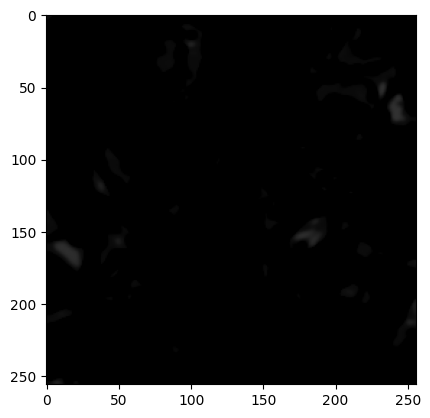

In [195]:
plt.imshow(Image.open('out_MID_0.png'))

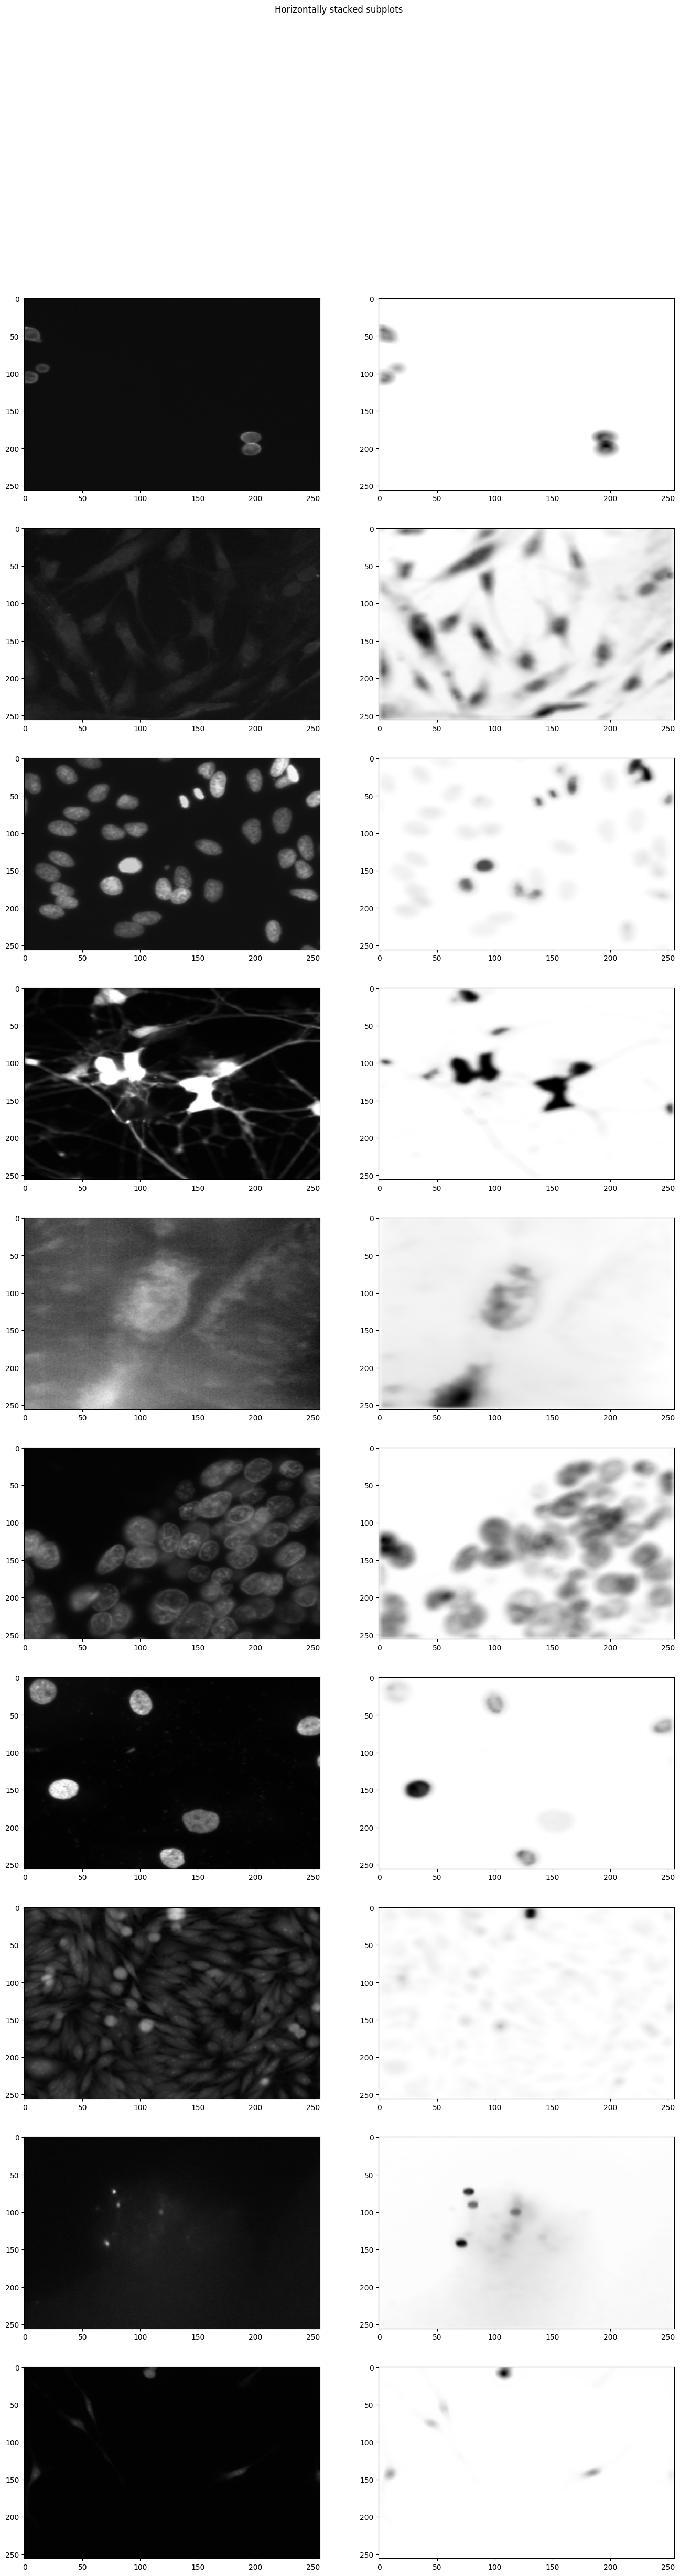

In [196]:
import matplotlib.pyplot as plt
a = unet(x.to(device))
fig, axs = plt.subplots(10, 2, figsize=(16, 56))
fig.suptitle('Horizontally stacked subplots')
for i in range(10):
  axs[i, 0].imshow(x[i].permute(1,2,0), aspect='auto')
  axs[i, 1].imshow(a[i][0].cpu().detach().numpy(), cmap= 'gray', aspect='auto')

In [197]:
%pip install pytorch-metric-learning
from IPython.display import clear_output
clear_output()

In [198]:
# from pytorch_metric_learning.losses import NTXentLoss

# encoder = Unet_encoder(3, 64)
# head = HeadProjection(1, 64, encoder).to(device)
# optimizer = torch.optim.Adam(head.parameters(), lr=0.001, weight_decay=1e-5)
# criterion = NTXentLoss(temperature=0.5)

# ############### LOAD THE SAVED MODEL ###################
# head.load_state_dict(torch.load("drive/MyDrive/Research/Self-Supervised/models_sanity_check/BaseLine_69.mdl"))

In [199]:
# encoder = Unet_encoder(3, 32)

In [200]:
encoder = unet.encoder.to(device)
unet = Unet(encoder,1,32).to(device)
# unet.load_state_dict(torch.load("drive/MyDrive/Research/Self-Supervised/models/SimCLR_88.pth"))
train_loss, val_loss, val_score = General(unet, 'Phase3_Last_Unet', 
                                          "./models_v3/", 
                                          'adam',False,0.001, 1e-5, 100,1)

1
train_loss:0.6202	trainig_score:[0.02523233 0.13699847 0.12126508 0.11905384 0.09764884 0.8768839 ]
  val_loss:0.3249	val_scores: 
 MaP: 0.0085 | Mean_Recall: 0.1137 | Mean_Prec: 0.0804 
         | Mean_F1: 0.0797 | Mean_IoU: 0.0580 | Mean_Acc: 0.8750
2
train_loss:0.2600	trainig_score:[0.03461881 0.12957594 0.1428458  0.13129793 0.11143899 0.87845063]
  val_loss:0.2165	val_scores: 
 MaP: 0.0205 | Mean_Recall: 0.1066 | Mean_Prec: 0.1164 
         | Mean_F1: 0.1042 | Mean_IoU: 0.0861 | Mean_Acc: 0.8791
3
train_loss:0.2017	trainig_score:[0.03055694 0.13596168 0.13241272 0.12857853 0.10778407 0.87898874]
  val_loss:0.2168	val_scores: 
 MaP: 0.0184 | Mean_Recall: 0.1111 | Mean_Prec: 0.1064 
         | Mean_F1: 0.0999 | Mean_IoU: 0.0808 | Mean_Acc: 0.8794
4
train_loss:0.1848	trainig_score:[0.09045    0.899667   0.31048068 0.4078658  0.29853433 0.89538765]
  val_loss:0.1736	val_scores: 
 MaP: 0.0925 | Mean_Recall: 0.9070 | Mean_Prec: 0.3086 
         | Mean_F1: 0.4023 | Mean_IoU: 0.2904 | M

In [204]:
val_score

[array([0.0084587 , 0.11373641, 0.08043674, 0.0796576 , 0.05799011,
        0.87497896], dtype=float32),
 array([0.02047627, 0.10659834, 0.11643372, 0.10421054, 0.08611774,
        0.8791461 ], dtype=float32),
 array([0.01839171, 0.11109397, 0.10641207, 0.09991619, 0.08079733,
        0.87943846], dtype=float32),
 array([0.09250504, 0.9069686 , 0.30859873, 0.4023154 , 0.29044068,
        0.8954492 ], dtype=float32),
 array([0.34043106, 0.83357435, 0.8025774 , 0.78830224, 0.67635894,
        0.9441333 ], dtype=float32),
 array([0.3859331 , 0.8420696 , 0.8303091 , 0.8129239 , 0.708874  ,
        0.94867766], dtype=float32),
 array([0.36878976, 0.8235825 , 0.84407914, 0.8111769 , 0.7062824 ,
        0.9488907 ], dtype=float32),
 array([0.35468978, 0.76965684, 0.9062641 , 0.8151177 , 0.70993453,
        0.95043975], dtype=float32),
 array([0.4520426 , 0.85378957, 0.85854876, 0.84120417, 0.7501017 ,
        0.9607666 ], dtype=float32),
 array([0.44323486, 0.82102555, 0.8998309 , 0.8458987 ,

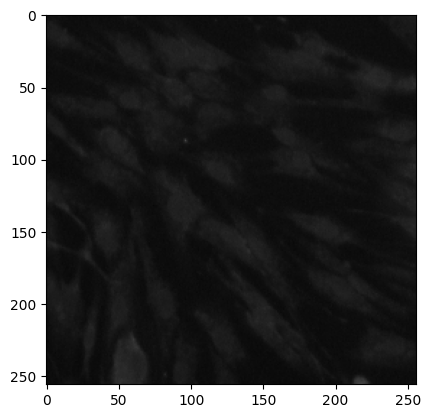

In [205]:
img = Image.open("img_3.png")
convert_tensor = transforms.ToTensor()
tt = convert_tensor(img)[None]
output = unet(tt.to(device))
output.size()
save_image(output[0], "out_3.png")
plt.imshow(img)

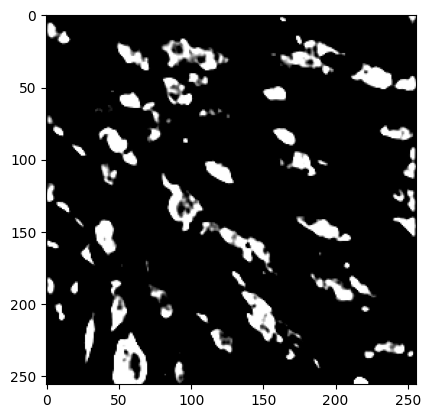

In [206]:
plt.imshow(Image.open("out_3.png"))

In [223]:
from torchvision.utils import save_image
a = torch.concat([a, a, a], axis=1)

output = unet(a.to(device))

for i in range(5):
  save_image(output[i], "out_" + str(i) + ".png")

torch.Size([25, 1, 256, 256])


Text(0.5, 1.0, 'Main Image')

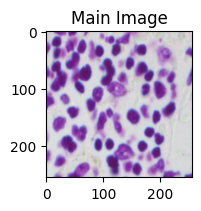

In [208]:
for idx, (x,y) in enumerate(valid_loader):
    x, y = x.to(device), y.to(device)
    outputs = unet(x)
    print(outputs.size())
    break

x, y, outputs = x.cpu().detach(), y.cpu().detach(), outputs.cpu().detach()
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(torch.permute(x[0],(1,2,0)))
ax.set_title('Main Image')

Text(0.5, 1.0, 'Ground Truth')

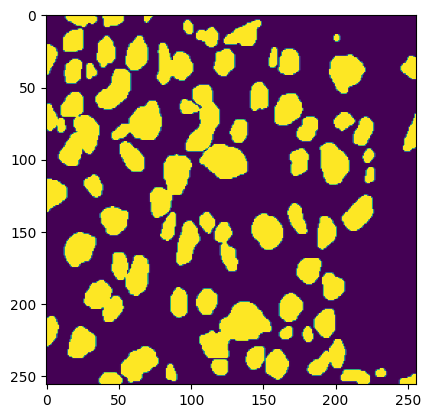

In [209]:
permuted_y = torch.permute(y[0],(1,2,0))
permuted_y = permuted_y[:,:,0]
imgplot = plt.imshow(permuted_y)
imgplot.set_clim(0.0, 0.7)
ax.set_title('Ground Truth')

Text(0.5, 1.0, 'Prediction')

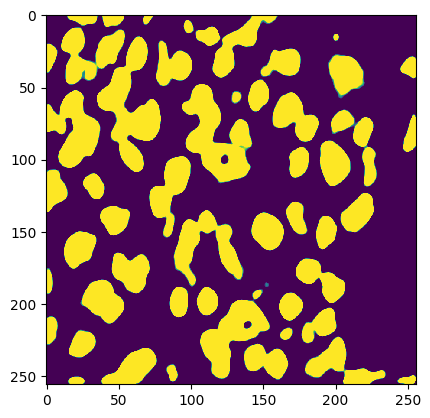

In [210]:
permuted_out = torch.permute(outputs[0],(1,2,0))
permuted_out = permuted_out[:,:,0]
imgplot = plt.imshow(permuted_out)
imgplot.set_clim(0.0, 0.7)
ax.set_title('Prediction')

In [217]:
criterion = nn.BCEWithLogitsLoss()
val_loss, val_score = evaluate(unet, test_loader, criterion, device)
print({'MaP': val_score[0], 'Mean_Recall': val_score[1], 'Mean_Precision': val_score[2],
       'Mean_F1': val_score[3], 'Mean_IOU': val_score[4], 'Mean_Accuracy': val_score[5]})

{'MaP': 0.567752, 'Mean_Recall': 0.8804048, 'Mean_Precision': 0.9240158, 'Mean_F1': 0.88969374, 'Mean_IOU': 0.813465, 'Mean_Accuracy': 0.98032606}
